# Classification from images with VGG-16 bottleneck features

In this example we build a clasification model to recognise differnet kinds of images. This example uses limited data and is inspired by the keras blog post "Building powerful image classification models using very little data" from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html. This example uses bottleneck features generated from a VGG-16 pre-trained model. An SVM model is then trained.

The datasets used are from kaggle 
* cats and dogs https://www.kaggle.com/c/dogs-vs-cats
* monkeys https://www.kaggle.com/slothkong/10-monkey-species/home 
* flowers https://www.kaggle.com/alxmamaev/flowers-recognition

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn import svm

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL

Using TensorFlow backend.


## Data

Set up the data set process. We provide the name of a folder contianing images. There are two assumptions:
* The images of differnet classes are contained in folders with class ids
* A csv file called class_labels exists which is a map from class ids to class names (for printing)

In [2]:
# dataset name
#dataset_name = '10-monkey-species'
dataset_name = 'flowers'
#dataset_name = 'cats_and_dogs'

# assuming data is contained in a train and a validation set
train_data_dir = dataset_name + '/train/'

# Set up some parmaeters for data loading
sample_rate = 1.0

# desired dimensions of our images.
img_width, img_height = 150, 150

# different backends (e.g. tensorflow and theano) use different orderings for image data - fix this!
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Load image data.

In [3]:
training_class_folders = [i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(training_class_folders)

# Initialise arrays for data storage
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)
    
# Loop through the class folders
for i, image_cls in enumerate(training_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = train_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

    # Iterate throuigh the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Low the images and resize them
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)        
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        # Add label to label array
        y_data = np.append(y_data, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_data = np.append(X_data, X_data_part, axis=0)
    
print("Data shape: {}".format(X_data.shape))

Processing class daisy
Processed 0 of 769 for class daisy 
Processed 100 of 769 for class daisy 
Processed 200 of 769 for class daisy 
Processed 300 of 769 for class daisy 
Processed 400 of 769 for class daisy 
Processed 500 of 769 for class daisy 
Processed 600 of 769 for class daisy 
Processed 700 of 769 for class daisy 
Processed 769 of 769 for class daisy 
Processing class rose
Processed 0 of 784 for class rose 
Processed 100 of 784 for class rose 
Processed 200 of 784 for class rose 
Processed 300 of 784 for class rose 
Processed 400 of 784 for class rose 
Processed 500 of 784 for class rose 
Processed 600 of 784 for class rose 
Processed 700 of 784 for class rose 
Processed 784 of 784 for class rose 
Processing class tulip
Processed 0 of 984 for class tulip 
Processed 100 of 984 for class tulip 
Processed 200 of 984 for class tulip 
Processed 300 of 984 for class tulip 
Processed 400 of 984 for class tulip 
Processed 500 of 984 for class tulip 
Processed 600 of 984 for class tuli

Split data into training and test partitions

In [4]:
# Perfrom split to train, validation, test
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)

Reshape output data for use with a neural network.

In [5]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_train_plus_valid_num = y_train_encoder.fit_transform(y_train_plus_valid)
y_train_plus_valid_wide = keras.utils.to_categorical(y_train_plus_valid_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

Record the number to label mapping 

In [6]:
classes_num_label = dict()

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl

Print a few randomly sampled example images.

/home/brianmacnamee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


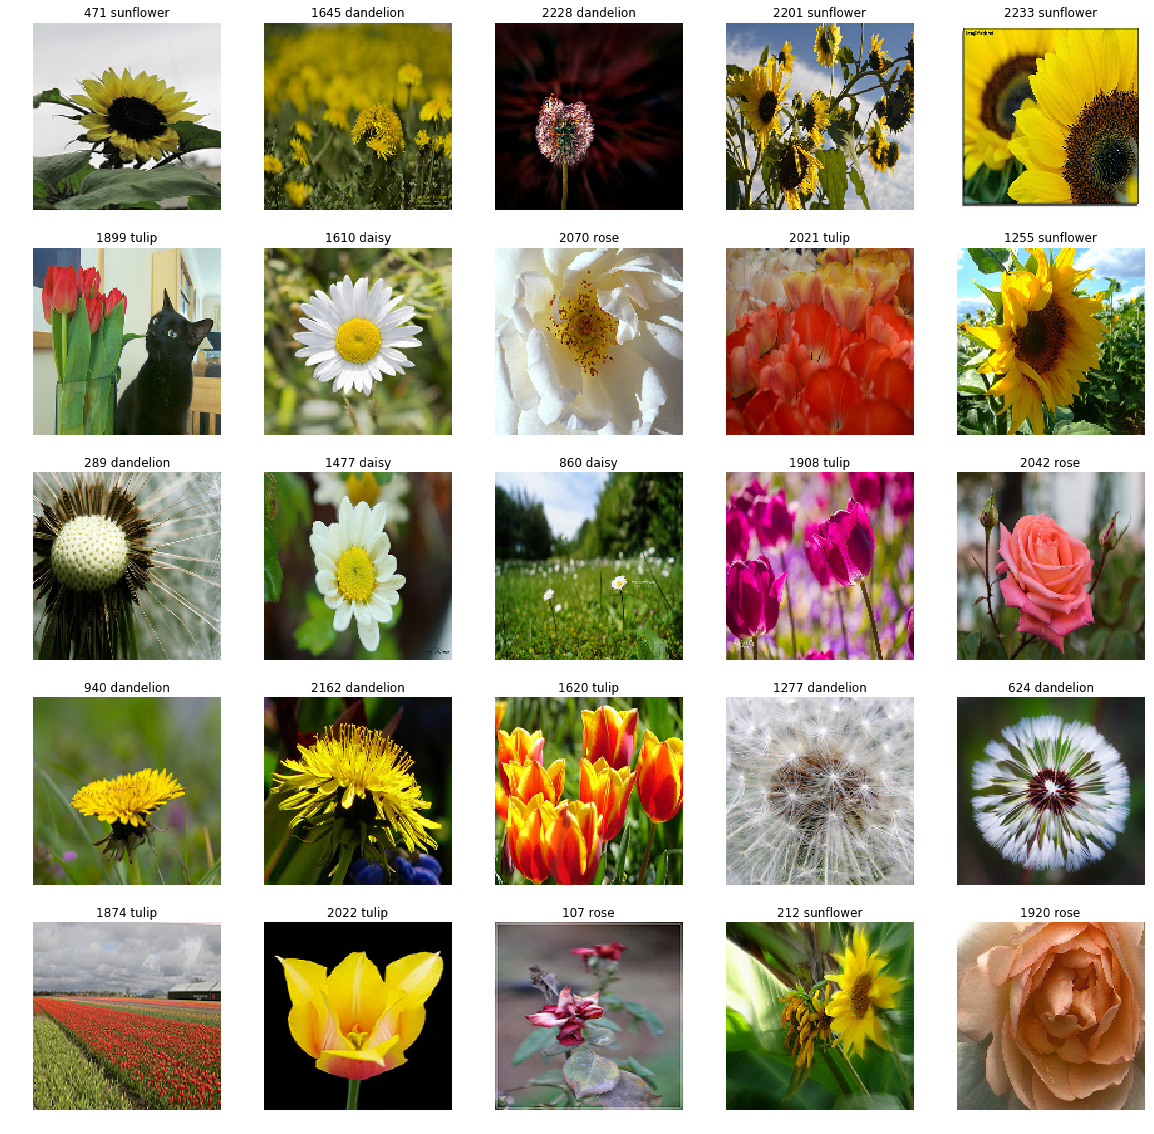

In [7]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train[i_rand]))
    plt.title((str(i_rand) + " " + y_train[i_rand]))

To generate bottleneck features first create a VGG16 model architecture with pre-trained weights. Omit the final dense layers.

In [8]:
# build the VGG16 network
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = X_train[0].shape)
display(vgg16_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

None

Make a prediction for each train, validation and test image using the truncated VGG16 model to generate bottleneck features. We reshape convolutional output to flatten it.

In [9]:
bottleneck_features_train_plus_valid = vgg16_model.predict(X_train_plus_valid)
bottleneck_features_train_plus_valid = bottleneck_features_train_plus_valid.reshape(bottleneck_features_train_plus_valid.shape[0], bottleneck_features_train_plus_valid.shape[1]*bottleneck_features_train_plus_valid.shape[2]*bottleneck_features_train_plus_valid.shape[3])

bottleneck_features_train = vgg16_model.predict(X_train)
bottleneck_features_train = bottleneck_features_train.reshape(bottleneck_features_train.shape[0], bottleneck_features_train.shape[1]*bottleneck_features_train.shape[2]*bottleneck_features_train.shape[3])

bottleneck_features_valid = vgg16_model.predict(X_valid)
bottleneck_features_valid = bottleneck_features_valid.reshape(bottleneck_features_valid.shape[0], bottleneck_features_valid.shape[1]*bottleneck_features_valid.shape[2]*bottleneck_features_valid.shape[3])

bottleneck_features_test = vgg16_model.predict(X_test)
bottleneck_features_test = bottleneck_features_test.reshape(bottleneck_features_test.shape[0], bottleneck_features_test.shape[1]*bottleneck_features_test.shape[2]*bottleneck_features_test.shape[3])

Write out the datasets for future use.

In [11]:
pd.DataFrame(np.c_[bottleneck_features_train, y_train]).to_csv("flowers_bottleneck_features_train.csv")
pd.DataFrame(np.c_[bottleneck_features_valid, y_valid]).to_csv("flowers_bottleneck_features_valid.csv")
pd.DataFrame(np.c_[bottleneck_features_test, y_test]).to_csv("flowers_bottleneck_features_test.csv")

## Modelling

Train a support vector machine classifier using the generated bottleneck features.

In [12]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(bottleneck_features_train_plus_valid, y_train_plus_valid_num) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'decision_function_shape':['ovo'],
                     'gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
                     'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5, verbose  = 2, n_jobs = -1)
clf.fit(bottleneck_features_train_plus_valid, y_train_plus_valid_num) 

Plot some evaluation stats

In [13]:
# Make a set of predictions for the validation data
pred = clf.predict(bottleneck_features_train)

# Print performance details
print(metrics.classification_report(y_train_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred))

             precision    recall  f1-score   support

          0       0.91      0.64      0.75       411
          1       0.79      0.86      0.82       602
          2       0.75      0.78      0.76       418
          3       0.81      0.70      0.76       410
          4       0.72      0.86      0.79       579

avg / total       0.79      0.78      0.78      2420

Confusion matrix
[[261  70  22  14  44]
 [  6 517   8  27  44]
 [  3  16 326  11  62]
 [ 13  33  34 289  41]
 [  3  16  46  14 500]]


## Evaluation

In [14]:
# Make a set of predictions for the validation data
pred = clf.predict(bottleneck_features_test)

# Print performance details
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

             precision    recall  f1-score   support

          0       0.86      0.59      0.70       251
          1       0.79      0.84      0.81       315
          2       0.73      0.72      0.73       240
          3       0.72      0.64      0.67       215
          4       0.63      0.82      0.71       276

avg / total       0.75      0.73      0.73      1297

Confusion matrix
[[149  36   9  20  37]
 [  8 264   6  14  23]
 [  2  12 173  11  42]
 [ 10  15  20 137  33]
 [  4   8  28   9 227]]


Draw some examples of correct classifications 

/home/brianmacnamee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


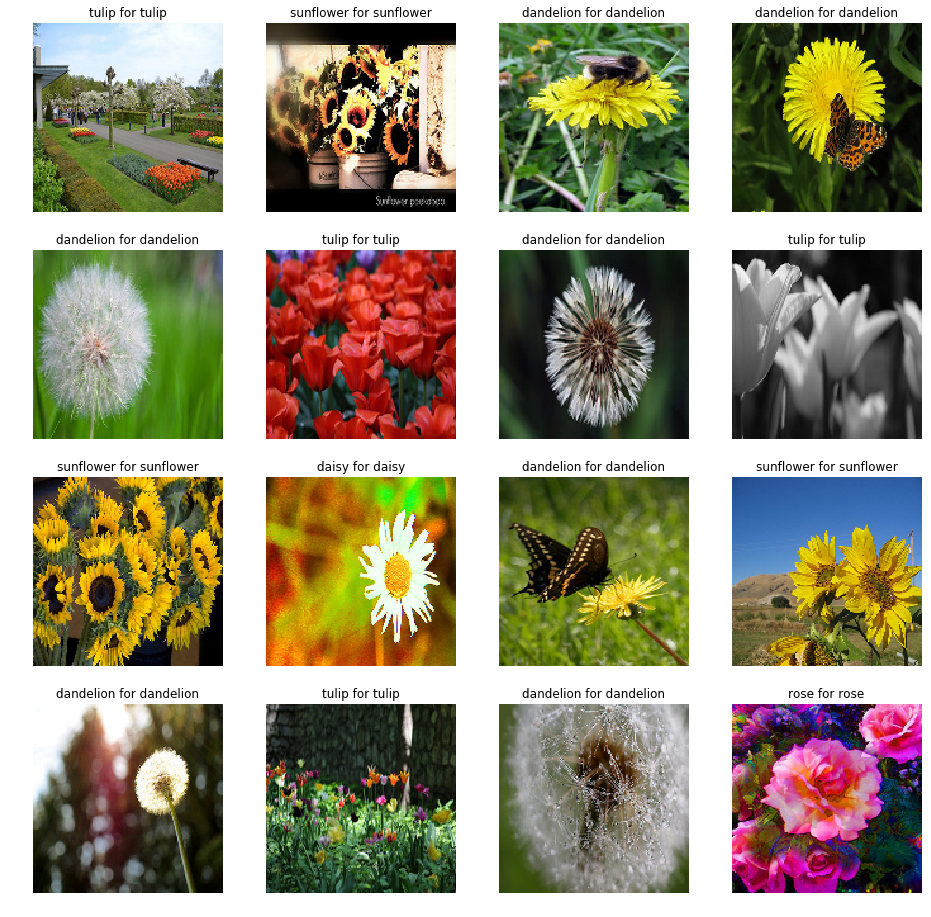

In [15]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(sp.misc.toimage(X_test[i]))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1

Draw some examples of mis-classifications 

/home/brianmacnamee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


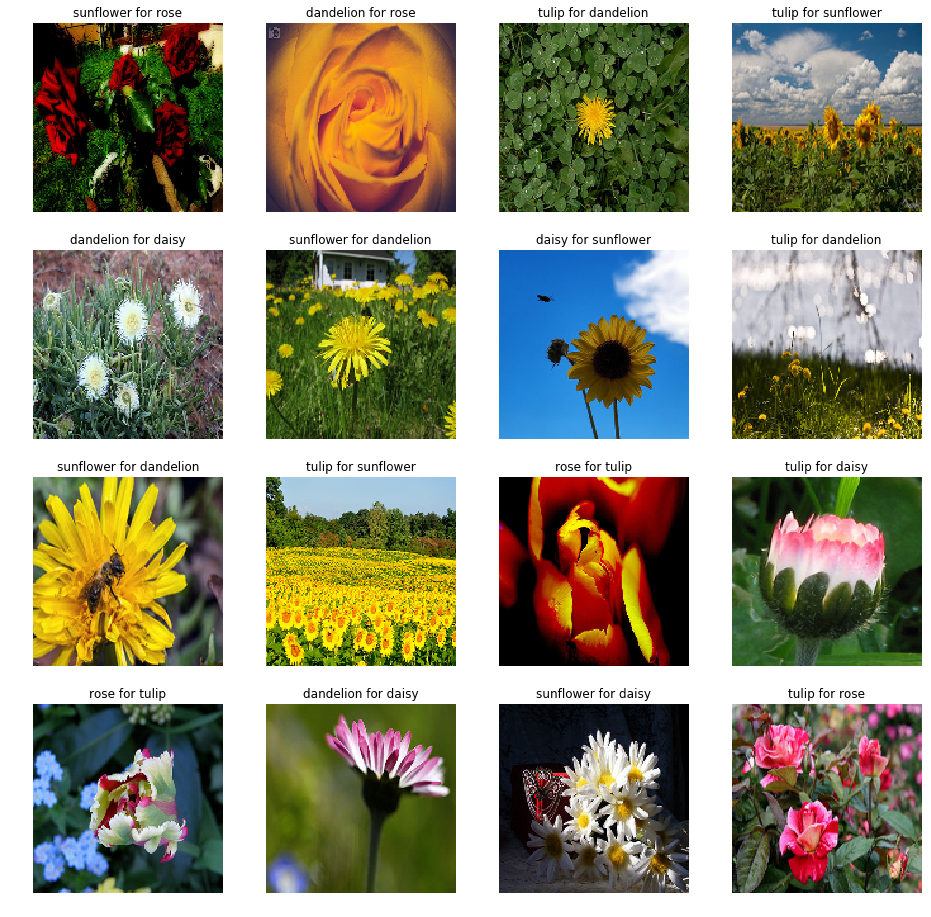

In [16]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
errors = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(sp.misc.toimage(X_test[i]))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1